In [2]:
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch

/home/nwertheim/miniconda3/bin/python


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc
wandb: Currently logged in as: noorwertheim to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import wandb
from fastai.callback.wandb import WandbCallback

# Initialize WandB logging
wandb.init(project='TCN-TSAI')

In [4]:
# from tsai.models.TCN import TCN
# import torch

# bs = 16
# nvars = 3         # number of input channels
# seq_len = 128     # sequence length
# c_out = 2         # number of output classes

# xb = torch.rand(bs, nvars, seq_len)
# model = TCN(c_in=nvars, c_out=c_out)
# output = model(xb)

# print(output.shape)  # should print: torch.Size([16, 2])


In [5]:
'''BALANCED DATA NO PCA'''

'''MY DATA'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)



import numpy as np

# Convert to numpy for easy indexing
train_windows = np.array(train_windows)
train_labels = np.array(train_labels)

# Get indices for each class
term_indices = np.where(train_labels == 0)[0]
preterm_indices = np.where(train_labels == 1)[0]

# Undersample the majority class (preterm) to match term
n_samples = min(len(term_indices), len(preterm_indices))
balanced_term_indices = np.random.choice(term_indices, n_samples, replace=False)
balanced_preterm_indices = np.random.choice(preterm_indices, n_samples, replace=False)

# Combine and shuffle
balanced_train_indices = np.concatenate([balanced_term_indices, balanced_preterm_indices])
np.random.shuffle(balanced_train_indices)

# Subset
train_windows_balanced = train_windows[balanced_train_indices]
train_labels_balanced = train_labels[balanced_train_indices]

test_windows = np.array(test_windows)
test_labels = np.array(test_labels)

term_indices = np.where(test_labels == 0)[0]
preterm_indices = np.where(test_labels == 1)[0]

n_samples = min(len(term_indices), len(preterm_indices))
balanced_term_indices = np.random.choice(term_indices, n_samples, replace=False)
balanced_preterm_indices = np.random.choice(preterm_indices, n_samples, replace=False)

balanced_test_indices = np.concatenate([balanced_term_indices, balanced_preterm_indices])
np.random.shuffle(balanced_test_indices)

test_windows_balanced = test_windows[balanced_test_indices]
test_labels_balanced = test_labels[balanced_test_indices]

train_windows = train_windows_balanced
train_labels = train_labels_balanced
test_windows = test_windows_balanced
test_labels = test_labels_balanced


# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)



# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0  # avoid multiprocessing issues
)


744
192
{'record_name': 'Hopper-2024_09_17_06_51_03-0000010009-0001-chan0', 'signal': array([[ -5.57103828],
       [-11.39992725],
       [ -9.53483776],
       ...,
       [  0.73235611],
       [ -0.1656677 ],
       [  1.35035514]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 3360
  Preterm (1): 3360

Test label distribution:
  Term (0): 390
  Preterm (1): 390
torch.Size([6720])


cuda:0


epoch,train_loss,valid_loss,accuracy,f1_score,time


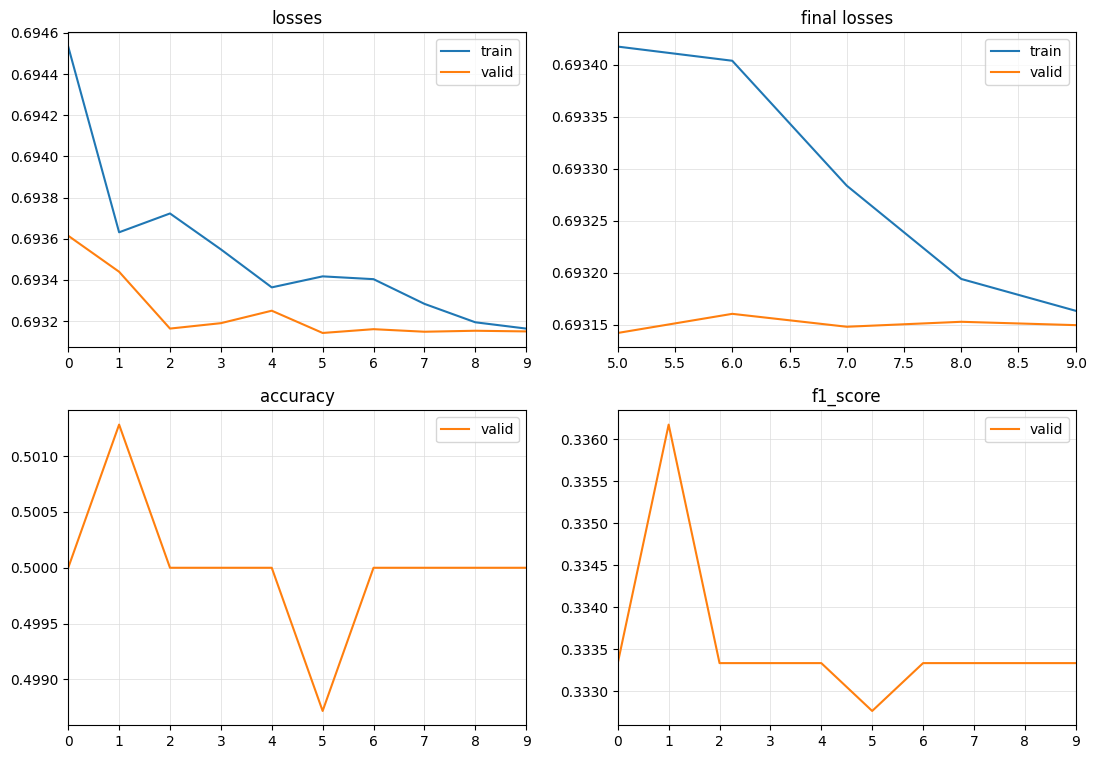

In [8]:
from tsai.models.TCN import TCN
from tsai.learner import Learner
from tsai.metrics import accuracy, F1Score
import torch
input_channels = 1
num_classes = 2

model = TCN(c_in=input_channels, c_out=num_classes).to(device)
print(next(model.parameters()).device)

import torch.nn as nn
from tsai.learner import Learner
from tsai.models.TCN import TCN
from tsai.metrics import accuracy, F1Score

loss_func = nn.CrossEntropyLoss()

learn = Learner(dls, TCN(c_in=1, c_out=2), loss_func=loss_func, metrics=[accuracy, F1Score(average='macro')])
learn.model.to(device)

learn.dls.to(device)

learn.fit_one_cycle(10, 1e-3)


# learn.show_results()
learn.plot_metrics()


In [7]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)


AttributeError: 'TensorDataset' object has no attribute 'vocab'